# Predicting SalePrice

## Objectives

Create and evaluate model to predict SalePrice of building

## Inputs:
* outputs/datasets/cleaned/test.parquet.gzip
* outputs/datasets/cleaned/train.parquet.gzip
* Conclusions from Feature Engineering jupyter_notebooks/04_Feature_Engineering.ipynb

## Outputs
* Train Set: Features and Target
* Test Set: Features and Target
* Feature Engineering Pipeline
* Modeling Pipeline
* Features Importance Plot

## Change working directory
In This section we will get location of current directory and move one step up, to parent folder, so App will be accessing project folder.

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os

current_dir = os.getcwd()
current_dir

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("you have set a new current directory")

Confirm new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

## Loading Dataset

In [ ]:
import pandas as pd

df_train = pd.read_parquet('outputs/datasets/cleaned/train.parquet.gzip')
df_train.head()
import pandas as pd

df_test = pd.read_parquet('outputs/datasets/cleaned/test.parquet.gzip')
df_train.head()

## Data Exploration
Before exploring data and doing transformations, as we decided earlier, we drop features:

In [ ]:
drop_features = ['Unnamed: 0']
df_train.drop(columns=drop_features, inplace=True)
df_test.drop(columns=drop_features, inplace=True)

## Splitting to data and test dataframe

In [ ]:
# Identify the target variable column name
target_column = 'SalePrice'

# Extract the target variable
y_train = df_train[target_column]
y_test = df_test[target_column]

# Remove the target variable from the DataFrame to create the feature DataFrame
X_train = df_train.drop(columns=[target_column])
X_test = df_test.drop(columns=[target_column])


## Machine Learning

### Pre-Transformations

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import category_encoders as ce

# Define custom FeatureCreator class
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np


class FeatureCreator(BaseEstimator, TransformerMixin):
    """Custom feature creator for pipeline integration.

    This class extends sklearn's TransformerMixin to allow for custom feature
    creation during preprocessing pipelines. It handles various mathematical
    transformations and feature interactions explicitly detailed within the
    transform method, ensuring all features are appropriately processed and added.

    """

    def fit(self, X, y=None):
        # The fit method is not used for adding features, it's just here for compatibility.
        return self

    def transform(self, X):
        """Apply a series of custom transformations to the dataframe.

        Args:
        X (pd.DataFrame): Input dataframe from which features are derived.

        Returns:
        pd.DataFrame: The dataframe with new features added.

        """
        X = X.copy()  # Work on a copy of the data to prevent changes to the original dataframe
        # Numeric and Boolean feature interactions and transformations
        X['xxx_TotalBsmtSF_mul_BsmtExposure'] = X['TotalBsmtSF'] * X['BsmtExposure']
        X['xxx_TotalBsmtSF_mul_BsmtFinType1'] = X['TotalBsmtSF'] * X['BsmtFinSF1']
        X['xxx_BsmtFinSF1_mul_BsmtFinType1'] = X['BsmtFinType1'] * X['BsmtFinSF1']
        X['xxx_GarageFinish_mul_GarageArea'] = X['GarageFinish'] * X['GarageArea']
        X['xxx_TotalLivingArea'] = X['GrLivArea'] + X['1stFlrSF'] + X['2ndFlrSF']
        X['xxx_TotalLivingArea_mul_OverallQual'] = X['xxx_TotalLivingArea'] * X['OverallQual']
        X['xxx_TotalLivingArea_mul_OverallCond'] = X['xxx_TotalLivingArea'] * X['OverallCond']
        X['xxx_1stFlrSF_mul_OverallQual'] = X['1stFlrSF'] * X['OverallQual']
        X['xxx_2ndFlrSF_mul_OverallQual'] = X['2ndFlrSF'] * X['OverallQual']
        X['xxx_Age_Garage'] = 2010 - X['GarageYrBlt']
        X['xxx_Age_Build'] = 2010 - X['YearBuilt']
        X['xxx_Age_Remod'] = 2010 - X['YearRemodAdd']
        X['xxx_Remod_TEST'] = X.apply(
            lambda row: 0 if row['xxx_Age_Build'] == row['xxx_Age_Remod'] else row['xxx_Age_Remod'], axis=1)
        X[('xxx_Has_2nd_floor')] = X.apply(lambda row: False if row['2ndFlrSF'] == 0 else True, axis=1).astype(int)
        X[('xxx_Has_basement')] = X.apply(lambda row: False if row['TotalBsmtSF'] == 0 else True, axis=1).astype(int)
        X[('xxx_Has_garage')] = X.apply(lambda row: False if row['GarageArea'] == 0 else True, axis=1).astype(int)
        X[('xxx_Has_Masonry_Veneer')] = X.apply(lambda row: False if row['MasVnrArea'] == 0 else True, axis=1).astype(
            int)
        X[('xxx_Has_Enclosed_Porch')] = X.apply(lambda row: False if row['EnclosedPorch'] == 0 else True,
                                                axis=1).astype(int)
        X[('xxx_Has_Open_Porch')] = X.apply(lambda row: False if row['OpenPorchSF'] == 0 else True, axis=1).astype(int)
        X['xxx_Has_ANY_Porch'] = X['xxx_Has_Enclosed_Porch'] | X['xxx_Has_Open_Porch'].astype(int)
        X[('xxx_Has_Wooden_Deck')] = X.apply(lambda row: False if row['WoodDeckSF'] == 0 else True, axis=1).astype(int)

        return X


# Mapping and encoder setup
encoding_dict = {
    'BsmtExposure': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
    'BsmtFinType1': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'GarageFinish': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
    'KitchenQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
}

ordinal_encoder = ce.OrdinalEncoder(mapping=[
    {'col': k, 'mapping': v} for k, v in encoding_dict.items()
])

# Pipeline setup
pre_feature_transformations = Pipeline(steps=[
    ('ordinal_encoder', ordinal_encoder),  # Custom categorical encoding
    ('feature_creator', FeatureCreator())  # Custom feature creation
])

### Features - Columns transformations

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from feature_engine.transformation import BoxCoxTransformer
from feature_engine.transformation import PowerTransformer as FeatureEnginePowerTransformer



# Custom transformer for DataFrame that applies transformation to specified columns
class DFColumnTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, columns):
        self.transformer = transformer
        self.columns = columns

    def fit(self, X, y=None):
        self.transformer.fit(X[self.columns], y)
        return self

    def transform(self, X):
        X = X.copy()
        X.loc[:, self.columns] = self.transformer.transform(X[self.columns])
        return X


# Define the columns for each transformation type
yeo_johnson_features = ['1stFlrSF','2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GarageFinish', 'GrLivArea', 'KitchenQual', 'LotArea', 'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'TotalBsmtSF', 'WoodDeckSF', 'xxx_TotalBsmtSF_mul_BsmtExposure','xxx_BsmtFinSF1_mul_BsmtFinType1', 'xxx_GarageFinish_mul_GarageArea', 'xxx_TotalLivingArea', 'xxx_Age_Garage', 'xxx_Age_Remod', 'xxx_Remod_TEST', 'xxx_TotalLivingArea_mul_OverallQual', 'xxx_TotalLivingArea_mul_OverallCond','xxx_1stFlrSF_mul_OverallQual','xxx_2ndFlrSF_mul_OverallQual']
power_features = [ 'GarageYrBlt', 'LotFrontage', 'YearRemodAdd','xxx_TotalBsmtSF_mul_BsmtFinType1', 'xxx_Age_Build']
box_cox_features = []

# Create transformers for each group of features
yeo_johnson_transformer = DFColumnTransformer(PowerTransformer(method='yeo-johnson', standardize=True),
                                              yeo_johnson_features)
power_transformer = DFColumnTransformer(FeatureEnginePowerTransformer(variables=power_features, exp=0.5), power_features)
box_cox_transformer = DFColumnTransformer(PowerTransformer(method='box-cox', standardize=True), box_cox_features)


# Combine all transformers into a single pipeline
feature_transformer = Pipeline([
    ('yeo_johnson', yeo_johnson_transformer),
    ('power', power_transformer),
])


### Features-Columns Post Transformations

In [ ]:
from feature_engine.outliers import Winsorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define the columns for Winsorization
winsorize_features = [ 'GarageArea', 'LotArea', 'LotFrontage', 'TotalBsmtSF', 'xxx_TotalBsmtSF_mul_BsmtExposure', 'xxx_TotalLivingArea_mul_OverallCond']

# Initialize the Winsorizer transformer
winsorize_transformer = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=winsorize_features)

# Create the post-feature transformations pipeline
post_feature_transformer = Pipeline([
    ('winsorize', winsorize_transformer),
])


### Target Transformations

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import numpy as np


class LogTransformer(BaseEstimator, TransformerMixin):
    """Applies a natural logarithm transformation to the target variable."""

    def fit(self, X, y=None):
        # This transformer does not need to learn anything from the data
        return self

    def transform(self, X):
        # Apply natural logarithm; np.log1p is used for numerical stability and handles X = 0
        return np.log1p(X)

    def inverse_transform(self, X):
        # Reverse the transformation using exponential; np.expm1 is used for numerical stability
        return np.expm1(X)


class CustomStandardScaler(BaseEstimator, TransformerMixin):
    """Standardizes the target variable by removing the mean and scaling to unit variance."""

    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X.reshape(-1, 1))
        return self

    def transform(self, X):
        return self.scaler.transform(X.reshape(-1, 1)).flatten()

    def inverse_transform(self, X):
        return self.scaler.inverse_transform(X.reshape(-1, 1)).flatten()


# Create a pipeline for transforming the target variable
target_transformation_pipeline = Pipeline([
    ('log_transform', LogTransformer()),  # Log transformation
])


class PassthroughTransformer(BaseEstimator, TransformerMixin):
    """A transformer that passes through the data without changing it."""

    def fit(self, X, y=None):
        # No fitting necessary for passthrough
        return self

    def transform(self, X):
        # Return the data as is
        return X

    def inverse_transform(self, X):
        # Return the data as is
        return X


# Create a pipeline for passthrough transformation
passthrough_transformation_pipeline = Pipeline([
    ('passthrough', PassthroughTransformer())  # Passthrough transformer
])



### Main Pipeline 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

def create_pipeline(model, target_transformer):
    """Create a pipeline with preprocessing, feature transformation, selection, and modeling."""

    # Define the complete pipeline
    main_pipeline = Pipeline([
        ('pre_transformations', pre_feature_transformations),  # Preprocessing steps
        ('transformations', feature_transformer),  # Feature transformations
        ('post_transformations', post_feature_transformer),  # Post-transformations
        ('feat_selection', SelectFromModel(model)),  # Feature selection
        ('model', TransformedTargetRegressor(regressor=model, transformer=target_transformer))  # Model with target transformation
    ])

    return main_pipeline


## ML Pipeline for Modeling and Hyperparameters Optimization

This is custom Class Hyperparameter Optimization

In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

class HyperparameterOptimizationSearch:
    """Class for hyperparameter optimization using GridSearchCV."""

    def __init__(self, models, params, target_transformer):
        """
        Initialize the HyperparameterOptimizationSearch class.

        :param models: Dictionary of model instances to be tuned.
        :param params: Dictionary of hyperparameters for the models.
        :param target_transformer: Transformer pipeline to apply to the target variable.
        """
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
        self.target_transformer = target_transformer

    def fit(self, X, y, cv, n_jobs, verbose=2, scoring=None, refit=False):
        """
        Fit GridSearchCV for each model in the provided models dictionary.

        :param X: Features dataset.
        :param y: Target dataset.
        :param cv: Cross-validation splitting strategy.
        :param n_jobs: Number of jobs to run in parallel.
        :param verbose: Verbosity level.
        :param scoring: Scoring metric.
        :param refit: Refit the best estimator with the entire dataset.
        """
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = create_pipeline(self.models[key], self.target_transformer)
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring, refit=refit)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        """
        Summarize the GridSearchCV results.

        :param sort_by: Column to sort the summary by.
        :return: DataFrame summarizing the GridSearchCV results and the grid searches.
        """
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            n_splits = self.grid_searches[k].cv  # Determine the number of splits used
            scores = []
            for i in range(n_splits):
                key = f"split{i}_test_score"
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append(row(k, s, p))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches



### Grid Search CV

For this time being we will use default hyperparameters, just to select best algorithms

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Initializing regression models with preprocessing pipelines and random state where applicable
models_quick_search = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=0),
    'RandomForestRegressor': RandomForestRegressor(random_state=0),
    'ExtraTreesRegressor': ExtraTreesRegressor(random_state=0),
    'AdaBoostRegressor': AdaBoostRegressor(random_state=0),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0),
    'XGBRegressor': XGBRegressor(random_state=0),
    'LGBMRegressor': LGBMRegressor(random_state=0),
    'CatBoostRegressor': CatBoostRegressor(random_state=0)
}

# Define hyperparameters for each model
params_quick_search = {
    'LinearRegression': {},
    'DecisionTreeRegressor': {},
    'RandomForestRegressor': {},
    'ExtraTreesRegressor': {},
    'AdaBoostRegressor': {},
    'GradientBoostingRegressor': {},
    'XGBRegressor': {},
    'LGBMRegressor': {},
    'CatBoostRegressor': {}
}


### Running Grid Search CV

In [ ]:
initial_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search, target_transformer=target_transformation_pipeline)
initial_search.fit(X_train, y_train, cv=5, n_jobs=-1, scoring='r2')

In [ ]:
import numpy as np

grid_search_summary, grid_search_pipelines = initial_search.score_summary(sort_by='mean_score')
grid_search_summary

We will save this initial search in: models/hypothesis_3/initial_run_1_pipelines.pkl , models/hypothesis_3/initial_run_1_summary.csv


In [ ]:
import joblib
joblib.dump(grid_search_pipelines, 'models/hypothesis_3/initial_run_1_pipelines.pkl')
grid_search_summary.to_csv('models/hypothesis_3/initial_run_1_summary.csv', index=False)

OK, now we have some Results:
1. CatBoostRegressor = 0.856164
2. LGBMRegressor = 0.851352
3. XGBRegressor = .808661

Let's evaluate each of them and see ups and downs

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the models
models_tune_search_cat = {
    "CatBoostRegressor": CatBoostRegressor(random_state=0, silent=False),
}

params_tune_search_cat = {
    "CatBoostRegressor": {
        'model__regressor__n_estimators': [100, 300],  # Number of boosting iterations
        'model__regressor__depth': [4, 6],  # Depth of the tree
        'model__regressor__learning_rate': [0.01, 0.1],  # Learning rate
        'model__regressor__l2_leaf_reg': [1, 5],  # L2 regularization term on weights
        'model__regressor__bagging_temperature': [0.5, 1.0],  # Bagging temperature for subsampling
        'model__regressor__border_count': [32, 50],  # Number of splits for numerical features
    }
}

# Optionally, you can add more depth and num_leaves combinations


In [ ]:
search_tuned_cat = HyperparameterOptimizationSearch(models=models_tune_search_cat, params=params_tune_search_cat, target_transformer=target_transformation_pipeline)
search_tuned_cat.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5, refit=True)

In [ ]:
models_tune_summary_cat, models_tune_pipelines_cat = search_tuned_cat.score_summary(sort_by='mean_score')
models_tune_summary_cat

In [ ]:
# Saving Summary and pipelines
joblib.dump(models_tune_pipelines_cat, 'models/hypothesis_3/cat_run_1_pipelines.pkl')
models_tune_summary_cat.to_csv('models/hypothesis_3/cat_run_1_summary.csv', index=False)

Selecting best model

Parameters for best model

In [ ]:
best_model_cat = models_tune_summary_cat.iloc[0, 0]
best_model_cat

In [ ]:
best_parameters_cat = models_tune_pipelines_cat[best_model_cat].best_params_
best_parameters_cat

In [ ]:
best_pipeline_cat = models_tune_pipelines_cat[best_model_cat].best_estimator_
best_pipeline_cat

## Accessing Feature Importance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

sns.set_style('whitegrid')
def plot_feature_importance(selected_pipeline, feat_eng_steps):
    try:
        # Number of data cleaning and feature engineering steps
        data_cleaning_feat_eng_steps = feat_eng_steps
    
        # Extract the sub-pipeline up to the feature engineering step
        transformer_pipeline = Pipeline(selected_pipeline.steps[:data_cleaning_feat_eng_steps])
    
        # Ensure the pipeline up to this point consists only of transformers
        if not hasattr(transformer_pipeline, 'transform'):
            raise AttributeError("The sub-pipeline does not support transform operation.")
    
        # Transform the training data
        X_transformed = transformer_pipeline.transform(X_train)
    
        # Get the transformed feature names
        if hasattr(X_transformed, 'columns'):
            transformed_feature_names = X_transformed.columns
        else:
            transformed_feature_names = [f'feature_{i}' for i in range(X_transformed.shape[1])]
    
        # Access the underlying model within TransformedTargetRegressor
        underlying_model = selected_pipeline['model'].regressor_
    
        # Get the support mask for the selected features
        feature_support_mask = selected_pipeline['feat_selection'].get_support()
    
        # Initialize all features importance with zero
        all_features = pd.DataFrame({
            'Feature': transformed_feature_names,
            'Importance': 0
        })
    
        if len(feature_support_mask) != len(transformed_feature_names):
            raise ValueError("The feature support mask length does not match the number of transformed features.")
    
        selected_features = pd.Index(transformed_feature_names)[feature_support_mask].to_list()
    
        # Extract feature importances from the model
        selected_importances = underlying_model.feature_importances_
    
        # Update the importance of the selected features
        for feature, importance in zip(selected_features, selected_importances):
            all_features.loc[all_features['Feature'] == feature, 'Importance'] = importance
    
        # Sort the DataFrame by importance
        all_features = all_features.sort_values(by='Importance', ascending=False)
    
    
        # Plotting the feature importances
        all_features.plot(kind='bar', x='Feature', y='Importance', color='blue', legend=None, figsize=(12, 8))
        plt.xlabel('Feature')
        plt.ylabel('Importance')
        plt.title('Feature Importances')
        plt.show()
    
    except AttributeError as e:
        print(f"Error: {e}")
    except ValueError as e:
        print(f"ValueError: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")


In [ ]:
plot_feature_importance(best_pipeline_cat, 3)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline

sns.set_style('whitegrid')
def plot_feature_importance_absolute(selected_pipeline, feat_eng_steps):
    try:
        # Number of data cleaning and feature engineering steps
        data_cleaning_feat_eng_steps = feat_eng_steps
    
        # Extract the sub-pipeline up to the feature engineering step
        transformer_pipeline = Pipeline(selected_pipeline.steps[:data_cleaning_feat_eng_steps])
    
        # Ensure the pipeline up to this point consists only of transformers
        if not hasattr(transformer_pipeline, 'transform'):
            raise AttributeError("The sub-pipeline does not support transform operation.")
    
        # Transform the training data
        X_transformed = transformer_pipeline.transform(X_train)
    
        # Get the transformed feature names
        if hasattr(X_transformed, 'columns'):
            transformed_feature_names = X_transformed.columns
        else:
            transformed_feature_names = [f'feature_{i}' for i in range(X_transformed.shape[1])]
    
        # Get the support mask for the selected features
        feature_support_mask = selected_pipeline['feat_selection'].get_support()
    
        if len(feature_support_mask) != len(transformed_feature_names):
            raise ValueError("The feature support mask length does not match the number of transformed features.")
    
        # Select the features and their importances
        selected_features = pd.Index(transformed_feature_names)[feature_support_mask].to_list()
        feature_importances = selected_pipeline['model'].regressor_.feature_importances_
    
        # DataFrame to display feature importances
        df_feature_importances = pd.DataFrame({
            'Feature': selected_features,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)
    
    
        # Plotting the feature importances
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=df_feature_importances)
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title('Feature Importances')
        plt.show()
    
    except AttributeError as e:
        print(f"Error: {e}")
    except ValueError as e:
        print(f"ValueError: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")


In [ ]:
plot_feature_importance_absolute(best_pipeline_cat, 3)

## Evaluating Model on Train and Test Sets

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    # Train plot
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0], color='blue')
    axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')  # Red line y=x
    axes[0].set_xlabel("Actual Values")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set Performance")

    # Test plot
    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1], color='green')
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Red line y=x
    axes[1].set_xlabel("Actual Values")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set Performance")

    plt.show()


In [ ]:
regression_performance(X_train, y_train, X_test, y_test, best_pipeline_cat)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline_cat)

## Results are way better than previous Hypothesis, but we can see model is Overfitted !

Train = 0.949
Test = 0.87

Let's see if it is possible to get same results without overfitting, or maybe even better!

Time for LGBMRegressor

In [ ]:
from lightgbm import LGBMRegressor

# Define the models
models_tune_search_lgbm = {
    "LGBMRegressor": LGBMRegressor(random_state=0),
}

# Define the parameter grid with appropriate num_leaves settings
params_tune_search_lgbm = {
    "LGBMRegressor": {
        'model__regressor__n_estimators': [100, 300],
        'model__regressor__max_depth': [3, 5, 10],  # Adjusted for practical ranges
        'model__regressor__learning_rate': [0.01, 0.1],
        'model__regressor__num_leaves': [2**3, 2**5, 2**10],  # Ensure num_leaves > 2^max_depth
        'model__regressor__min_child_samples': [20, 40],
    }
}

# Optionally, you can add more depth and num_leaves combinations


In [ ]:
search_tuned_lgbm = HyperparameterOptimizationSearch(models=models_tune_search_lgbm, params=params_tune_search_lgbm, target_transformer=target_transformation_pipeline)
search_tuned_lgbm.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5, refit=True)

In [ ]:
models_tune_summary_lgbm, models_tune_pipelines_lgbm = search_tuned_lgbm.score_summary(sort_by='mean_score')
models_tune_summary_lgbm

In [ ]:
# Saving Summary and pipelines
joblib.dump(models_tune_pipelines_lgbm, 'models/hypothesis_3/lgbm_run_1_pipelines.pkl')
models_tune_summary_lgbm.to_csv('models/hypothesis_3/lgbm_run_1_summary.csv', index=False)

In [ ]:
best_model_lgbm = models_tune_summary_lgbm.iloc[0, 0]
best_model_lgbm

In [ ]:
best_parameters_lgbm = models_tune_pipelines_lgbm[best_model_lgbm].best_params_
best_parameters_lgbm

In [ ]:
best_pipeline_lgbm = models_tune_pipelines_lgbm[best_model_lgbm].best_estimator_
best_pipeline_lgbm

In [ ]:
plot_feature_importance(best_pipeline_lgbm, 3)

In [ ]:
plot_feature_importance_absolute(best_pipeline_lgbm, 3)

In [ ]:
regression_performance(X_train, y_train, X_test, y_test, best_pipeline_lgbm)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline_lgbm)

Results a bit worse that CATBoostRegressor:

Train = 0.926
Test = 0.817

Time for XGBRegressor

In [ ]:
from xgboost import XGBRegressor

# Define the models
models_tune_search_xgb = {
    "XGBRegressor": XGBRegressor(random_state=0),
}

# Define the parameter grid with appropriate num_leaves settings
params_tune_search_xgb = {
    "XGBRegressor": {
        'model__regressor__n_estimators': [100, 300],
        'model__regressor__max_depth': [3, 5, 10],
        'model__regressor__learning_rate': [0.01, 0.1],
        'model__regressor__subsample': [0.8, 1.0],
        'model__regressor__colsample_bytree': [0.8, 1.0],
        'model__regressor__min_child_weight': [1, 5, 10],
    }
}

In [ ]:
search_tuned_xgb = HyperparameterOptimizationSearch(models=models_tune_search_xgb, params=params_tune_search_xgb, target_transformer=target_transformation_pipeline)
search_tuned_xgb.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5, refit=True)

In [ ]:
models_tune_summary_xgb, models_tune_pipelines_xgb = search_tuned_xgb.score_summary(sort_by='mean_score')
models_tune_summary_xgb

In [ ]:
# Saving Summary and pipelines
joblib.dump(models_tune_pipelines_xgb, 'models/hypothesis_3/xgb_run_1_pipelines.pkl')
models_tune_summary_xgb.to_csv('models/hypothesis_3/xgb_run_1_summary.csv', index=False)

In [ ]:
best_model_xgb = models_tune_summary_xgb.iloc[0, 0]
best_model_xgb

In [ ]:
best_parameters_xgb = models_tune_pipelines_xgb[best_model_xgb].best_params_
best_parameters_xgb

In [ ]:
best_pipeline_xgb = models_tune_pipelines_xgb[best_model_xgb].best_estimator_
best_pipeline_xgb

In [ ]:
plot_feature_importance(best_pipeline_xgb, 3)

In [ ]:
plot_feature_importance_absolute(best_pipeline_xgb, 3)

In [ ]:
regression_performance(X_train, y_train, X_test, y_test, best_pipeline_xgb)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline_xgb)

OK, we see model is still trying to overfit.

Train = 0.897
Test = 0.801


### Fixing Overfitting

To fix overfitting we have few options:
1. Remove Noise - yes we have lots of features that are correlated between themselves (thanks to new sub_features)
2. Transformations changing
3. Scaling
4. Smart Correlation

We will skip 1 and 4 options. We can apply them anytime later, as any data is still data and can be important. First try to improve model accuracy with all data we have (Dumping some data is bad, as someone spent time on it, also it can be important for model in certain scenarios)

### Changing Transformations and applying Scaling

As per Table from Feature engineering No 8, we will discard all Transformations with Yeo Johnson and Box Cox. According to Sklearn, if dataset is small they can make it overfit.

We will proceed in this pattern:

1. We will apply Scaling to all Features, so all of them will be more or less important, maybe models will not focus on those features that are so much correlated between themselves or have higher values.
2. We will also apply Winsorizer only to those features that have High or X High outliers. Hope this will do a trick for models.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from feature_engine.transformation import PowerTransformer as FeatureEnginePowerTransformer

class DFColumnTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, columns):
        self.transformer = transformer
        self.columns = columns

    def fit(self, X, y=None):
        self.transformer.fit(X[self.columns], y)
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed[self.columns] = self.transformer.transform(X[self.columns])
        return X_transformed

power_features = ['2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtUnfSF', 'EnclosedPorch', 'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'WoodDeckSF', 'YearRemodAdd', 'xxx_TotalBsmtSF_mul_BsmtExposure', 'xxx_TotalBsmtSF_mul_BsmtFinType1', 'xxx_BsmtFinSF1_mul_BsmtFinType1', 'xxx_GarageFinish_mul_GarageArea', 'xxx_Age_Garage', 'xxx_Age_Build', 'xxx_Age_Remod', 'xxx_Remod_TEST', 'xxx_TotalLivingArea_mul_OverallQual', 'xxx_1stFlrSF_mul_OverallQual', 'xxx_2ndFlrSF_mul_OverallQual']
log_e_features = ['1stFlrSF', 'LotArea', 'xxx_TotalLivingArea', 'xxx_TotalLivingArea', 'xxx_TotalLivingArea_mul_OverallCond']

# Create transformers for each group of features
power_transformer = DFColumnTransformer(FeatureEnginePowerTransformer(variables=power_features, exp=0.5), power_features)
log_transformer = DFColumnTransformer(FunctionTransformer(np.log1p, validate=True), log_e_features)

# Combine all transformers into a single pipeline
feature_transformer = Pipeline([
    ('power', power_transformer),
    ('log', log_transformer)
])


In [ ]:
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

# Define the columns for Winsorization
winsorize_features = ['GarageArea', 'LotArea', 'LotFrontage', 'TotalBsmtSF', 'xxx_TotalBsmtSF_mul_BsmtExposure', 'xxx_TotalLivingArea_mul_OverallCond', 'xxx_1stFlrSF_mul_OverallQual']

# Initialize the Winsorizer transformer
winsorize_transformer = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=winsorize_features)

# Custom transformer to extract feature names
class FeatureExtractor(BaseEstimator, TransformerMixin):
    """Extracts feature names from the dataframe and stores them."""
    def fit(self, X, y=None):
        self.feature_names = X.columns.tolist()
        return self

    def transform(self, X):
        return X

# Custom scaler to use extracted feature names
class CustomStandardScaler(BaseEstimator, TransformerMixin):
    """Standard Scaler that uses feature names dynamically."""
    def fit(self, X, y=None):
        self.scaler = StandardScaler()
        self.feature_names = X.columns.tolist()
        self.scaler.fit(X)
        return self

    def transform(self, X):
        X_scaled = self.scaler.transform(X)
        return pd.DataFrame(X_scaled, columns=self.feature_names, index=X.index)

# Create the post-feature transformations pipeline
post_feature_transformer = Pipeline([
    ('winsorize', winsorize_transformer),
    ('feature_extractor', FeatureExtractor()),
    ('scaler', CustomStandardScaler()),
])


### Starting Grid CV searches

In [ ]:
initial_search_1 = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search, target_transformer=target_transformation_pipeline)
initial_search_1.fit(X_train, y_train, cv=5, n_jobs=-1, scoring='r2')

In [ ]:
import numpy as np

grid_search_summary_1, grid_search_pipelines_1 = initial_search_1.score_summary(sort_by='mean_score')
grid_search_summary_1

In [ ]:
import joblib
joblib.dump(grid_search_pipelines_1, 'models/hypothesis_3/initial_run_2_pipelines.pkl')
grid_search_summary_1.to_csv('models/hypothesis_3/initial_run_2_summary.csv', index=False)

OK, we see the same all 3 Regressors at the top:
1. CatBoostRegressor = 0.851244
2. LGBMRegressor = 0.85027
3. XGBRegressor = 0.769793, ExtraTreesRegressor also close to 3rd place 0.767443

Let's try them again all individually

In [ ]:
search_tuned_cat_2 = HyperparameterOptimizationSearch(models=models_tune_search_cat, params=params_tune_search_cat, target_transformer=target_transformation_pipeline)
search_tuned_cat_2.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5, refit=True)

In [ ]:
models_tune_summary_cat_2, models_tune_pipelines_cat_2 = search_tuned_cat_2.score_summary(sort_by='mean_score')
models_tune_summary_cat_2

In [ ]:
# Saving Summary and pipelines
joblib.dump(models_tune_pipelines_cat_2, 'models/hypothesis_3/cat_run_2_pipelines.pkl')
models_tune_summary_cat_2.to_csv('models/hypothesis_3/cat_run_2_summary.csv', index=False)

In [ ]:
best_model_cat_2 = models_tune_summary_cat_2.iloc[0, 0]
best_model_cat_2

In [ ]:
best_parameters_cat_2 = models_tune_pipelines_cat_2[best_model_cat_2].best_params_
best_parameters_cat_2

In [ ]:
best_pipeline_cat_2 = models_tune_pipelines_cat_2[best_model_cat_2].best_estimator_
best_pipeline_cat_2

In [ ]:
plot_feature_importance(best_pipeline_cat_2, 3)

In [ ]:
plot_feature_importance_absolute(best_pipeline_cat_2, 3)

In [ ]:
regression_performance(X_train, y_train, X_test, y_test, best_pipeline_cat_2)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline_cat_2)

Uhhh Ohhh YES!!! we managed to increase performance:

Train = 0.943
Test = 0.876

Still Overfitted.

Testing LGBMRegressor

In [ ]:
search_tuned_lgbm_2 = HyperparameterOptimizationSearch(models=models_tune_search_lgbm, params=params_tune_search_lgbm, target_transformer=target_transformation_pipeline)
search_tuned_lgbm_2.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5, refit=True)

In [ ]:
models_tune_summary_lgbm_2, models_tune_pipelines_lgbm_2 = search_tuned_lgbm_2.score_summary(sort_by='mean_score')
models_tune_summary_lgbm_2

In [ ]:
# Saving Summary and pipelines
joblib.dump(models_tune_pipelines_lgbm_2, 'models/hypothesis_3/lgbm_run_2_pipelines.pkl')
models_tune_summary_lgbm_2.to_csv('models/hypothesis_3/lgbm_run_2_summary.csv', index=False)

In [ ]:
best_model_lgbm_2 = models_tune_summary_lgbm_2.iloc[0, 0]
best_model_lgbm_2

In [ ]:
best_parameters_lgbm_2 = models_tune_pipelines_lgbm_2[best_model_lgbm_2].best_params_
best_parameters_lgbm_2

In [ ]:
best_pipeline_lgbm_2 = models_tune_pipelines_lgbm_2[best_model_lgbm_2].best_estimator_
best_pipeline_lgbm_2

In [ ]:
plot_feature_importance(best_pipeline_lgbm_2, 3)

In [ ]:
plot_feature_importance_absolute(best_pipeline_lgbm_2, 3)

In [ ]:
regression_performance(X_train, y_train, X_test, y_test, best_pipeline_lgbm_2)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline_lgbm_2)

Yeah... not as good as CAT... and still overfitted:
Train = 0.939
Test = 0.833

Time for XGB

In [ ]:
search_tuned_xgb_2 = HyperparameterOptimizationSearch(models=models_tune_search_xgb, params=params_tune_search_xgb, target_transformer=target_transformation_pipeline)
search_tuned_xgb_2.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5, refit=True)

In [ ]:
models_tune_summary_xgb_2, models_tune_pipelines_xgb_2 = search_tuned_xgb_2.score_summary(sort_by='mean_score')
models_tune_summary_xgb_2

In [ ]:
# Saving Summary and pipelines
joblib.dump(models_tune_pipelines_xgb_2, 'models/hypothesis_3/xgb_run_2_pipelines.pkl')
models_tune_summary_xgb_2.to_csv('models/hypothesis_3/xgb_run_2_summary.csv', index=False)

In [ ]:
best_model_xgb_2 = models_tune_summary_xgb_2.iloc[0, 0]
best_model_xgb_2

In [ ]:
best_parameters_xgb_2 = models_tune_pipelines_xgb_2[best_model_xgb_2].best_params_
best_parameters_xgb_2

In [ ]:
best_pipeline_xgb_2 = models_tune_pipelines_xgb_2[best_model_xgb_2].best_estimator_
best_pipeline_xgb_2

In [ ]:
plot_feature_importance(best_pipeline_xgb_2, 3)

In [ ]:
plot_feature_importance_absolute(best_pipeline_xgb_2, 3)

In [ ]:
regression_performance(X_train, y_train, X_test, y_test, best_pipeline_xgb_2)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline_xgb_2)

Same again... overfitted and lower than CAT:
Train = 0.882
Test = 0.783

## Outcome

We can keep fine_tuning CAT Boost Regressor after that implement PCA to select just important Features.

Or we can remember, that in our Feature Engineering we said, that there will be a lot of new features that are correlated between themselves.  
Lets try Different regressors that can work with such case:

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, QuantileRegressor, RANSACRegressor, Lars, OrthogonalMatchingPursuit
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.cross_decomposition import PLSRegression

# Initializing regression models with default hyperparameters and random state where applicable
models_quick_search_2 = {
    'Ridge': Ridge(random_state=0),
    'ElasticNet': ElasticNet(random_state=0),
    'BayesianRidge': BayesianRidge(),
    'QuantileRegressor': QuantileRegressor(),
    'OrthogonalMatchingPursuit': OrthogonalMatchingPursuit(),
    'PLSRegression': PLSRegression(),
}

# Define hyperparameters for each model (empty dictionaries since we use default settings)
params_quick_search_2 = {
    'Ridge': {
        'model__regressor__alpha': [0.1, 1.0, 10.0]
    },
    'ElasticNet': {},
    'BayesianRidge': {},
    'QuantileRegressor': {},
    'OrthogonalMatchingPursuit': {},
    'PLSRegression': {},
}


In [ ]:
initial_search_3 = HyperparameterOptimizationSearch(models=models_quick_search_2, params=params_quick_search_2, target_transformer=target_transformation_pipeline)
initial_search_3.fit(X_train, y_train, cv=5, n_jobs=-1, scoring='r2')

In [ ]:
import numpy as np

grid_search_summary_3, grid_search_pipelines_3 = initial_search_3.score_summary(sort_by='mean_score')
grid_search_summary_3

OK, and we have our contextants:
1. PLSRegression = 0.84874
2. Ridge = 0.809668
3. BayesianRidge = 0.805027

In [ ]:
import joblib
joblib.dump(grid_search_pipelines_3, 'models/hypothesis_3/initial_run_3_pipelines.pkl')
grid_search_summary_3.to_csv('models/hypothesis_3/initial_run_3_summary.csv', index=False)

In [88]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the models
models_tune_search_pls = {
    "PLSRegression": PLSRegression()
}

# Define the hyperparameters for GridSearchCV
params_tune_search_pls = {
    "PLSRegression": {
        'model__regressor__n_components': [2, 4, 6, 8, 10],  # Number of PLS components to use
        'model__regressor__scale': [True, False],  # Whether to scale data before fitting
        'model__regressor__max_iter': [500, 1000, 2000]  # Maximum number of iterations of the algorithm
    }
}

In [89]:
search_tuned_pls = HyperparameterOptimizationSearch(models=models_tune_search_pls, params=params_tune_search_pls, target_transformer=target_transformation_pipeline)
search_tuned_pls.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5, refit=True)


Running GridSearchCV for PLSRegression 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [90]:
models_tune_summary_pls, models_tune_pipelines_pls = search_tuned_pls.score_summary(sort_by='mean_score')
models_tune_summary_pls

,estimator,min_score,mean_score,max_score,std_score,model__regressor__max_iter,model__regressor__n_components,model__regressor__scale
14,PLSRegression,0.672923,0.852065,0.90409,0.090025,1000,6,True
24,PLSRegression,0.672923,0.852065,0.90409,0.090025,2000,6,True
4,PLSRegression,0.672923,0.852065,0.90409,0.090025,500,6,True
15,PLSRegression,0.672923,0.852065,0.90409,0.090025,1000,6,False
5,PLSRegression,0.672923,0.852065,0.90409,0.090025,500,6,False
25,PLSRegression,0.672923,0.852065,0.90409,0.090025,2000,6,False
6,PLSRegression,0.669582,0.84988,0.902727,0.090521,500,8,True
7,PLSRegression,0.669582,0.84988,0.902727,0.090521,500,8,False
27,PLSRegression,0.669582,0.84988,0.902727,0.090521,2000,8,False
26,PLSRegression,0.669582,0.84988,0.902727,0.090521,2000,8,True


In [91]:
# Saving Summary and pipelines
joblib.dump(models_tune_pipelines_pls, 'models/hypothesis_3/pls_run_1_pipelines.pkl')
models_tune_summary_pls.to_csv('models/hypothesis_3/pls_run_1_summary.csv', index=False)

In [92]:
best_model_pls = models_tune_summary_pls.iloc[0, 0]
best_model_pls

'PLSRegression'

In [93]:
best_parameters_pls = models_tune_pipelines_pls[best_model_pls].best_params_
best_parameters_pls

{'model__regressor__max_iter': 500,
 'model__regressor__n_components': 6,
 'model__regressor__scale': True}

In [94]:
best_pipeline_pls = models_tune_pipelines_pls[best_model_pls].best_estimator_
best_pipeline_pls

Pipeline(steps=[('pre_transformations',
                 Pipeline(steps=[('ordinal_encoder',
                                  OrdinalEncoder(cols=['BsmtExposure',
                                                       'BsmtFinType1',
                                                       'GarageFinish',
                                                       'KitchenQual'],
                                                 mapping=[{'col': 'BsmtExposure',
                                                           'data_type': dtype('O'),
                                                           'mapping': None    0
No      1
Mn      2
Av      3
Gd      4
dtype: int64},
                                                          {'col': 'BsmtFinType1',
                                                           'data_type': dtype('O'),
                                                           'mapping': None    0
Unf     1
LwQ     2
Rec     3
BLQ     4
ALQ     5
GLQ     6
dtype: int64},
                                                          {'co...
                                                        'xxx_TotalLivingArea_mul_OverallCond',
                                                        'xxx_1stFlrSF_mul_OverallQual'])),
                                 ('feature_extractor', FeatureExtractor()),
                                 ('scaler', CustomStandardScaler())])),
                ('feat_selection', SelectFromModel(estimator=PLSRegression())),
                ('model',
                 TransformedTargetRegressor(regressor=PLSRegression(n_components=6),
                                            transformer=Pipeline(steps=[('log_transform',
                                                                         LogTransformer())])))])

Model Evaluation 

* Train Set
R2 Score: 0.858
Mean Absolute Error: 17990.014


* Test Set
R2 Score: 0.447
Mean Absolute Error: 22781.389




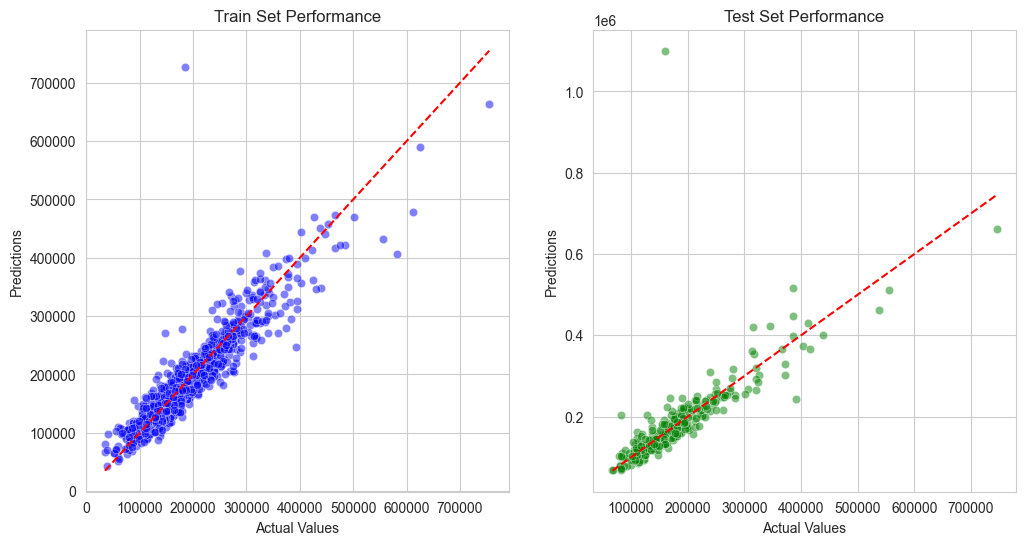

In [97]:
regression_performance(X_train, y_train, X_test, y_test, best_pipeline_pls)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline_pls)

This is Total Failure...

Train = 0.858
Test = 0.447

Time for Ridge

In [98]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define the models
models_tune_search_ridge = {
    "Ridge": Ridge(random_state=0)
}

# Define the hyperparameters for GridSearchCV
params_tune_search_ridge = {
    "Ridge": {
        'model__regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength
        'model__regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],  # Solver to use
        'model__regressor__max_iter': [None, 1000, 5000, 10000]  # Maximum number of iterations for some solvers
    }
}

In [99]:
search_tuned_ridge = HyperparameterOptimizationSearch(models=models_tune_search_ridge, params=params_tune_search_ridge, target_transformer=target_transformation_pipeline)
search_tuned_ridge.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5, refit=True)


Running GridSearchCV for Ridge 

Fitting 5 folds for each of 140 candidates, totalling 700 fits
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [100]:
models_tune_summary_ridge, models_tune_pipelines_ridge = search_tuned_ridge.score_summary(sort_by='mean_score')
models_tune_summary_ridge

,estimator,min_score,mean_score,max_score,std_score,model__regressor__alpha,model__regressor__max_iter,model__regressor__solver
139,Ridge,0.598987,0.821921,0.901816,0.112551,100.0,10000,saga
132,Ridge,0.598987,0.821921,0.901816,0.112551,100.0,5000,saga
125,Ridge,0.598987,0.821921,0.901816,0.112551,100.0,1000,saga
118,Ridge,0.598987,0.821921,0.901816,0.112551,100.0,None,saga
138,Ridge,0.59898,0.821919,0.901814,0.112553,100.0,10000,sag
...,...,...,...,...,...,...,...,...
15,Ridge,0.498364,0.789554,0.88836,0.146379,0.01,5000,svd
25,Ridge,0.496835,0.789407,0.888562,0.147059,0.01,10000,sparse_cg
11,Ridge,0.496835,0.789407,0.888562,0.147059,0.01,1000,sparse_cg
4,Ridge,0.496835,0.789407,0.888562,0.147059,0.01,None,sparse_cg


In [101]:
# Saving Summary and pipelines
joblib.dump(models_tune_pipelines_ridge, 'models/hypothesis_3/ridge_run_1_pipelines.pkl')
models_tune_summary_ridge.to_csv('models/hypothesis_3/ridge_run_1_summary.csv', index=False)

In [102]:
best_model_ridge = models_tune_summary_ridge.iloc[0, 0]
best_model_ridge

'Ridge'

In [103]:
best_parameters_ridge = models_tune_pipelines_ridge[best_model_ridge].best_params_
best_parameters_ridge

{'model__regressor__alpha': 100.0,
 'model__regressor__max_iter': None,
 'model__regressor__solver': 'saga'}

In [104]:
best_pipeline_ridge = models_tune_pipelines_ridge[best_model_ridge].best_estimator_
best_pipeline_ridge

Pipeline(steps=[('pre_transformations',
                 Pipeline(steps=[('ordinal_encoder',
                                  OrdinalEncoder(cols=['BsmtExposure',
                                                       'BsmtFinType1',
                                                       'GarageFinish',
                                                       'KitchenQual'],
                                                 mapping=[{'col': 'BsmtExposure',
                                                           'data_type': dtype('O'),
                                                           'mapping': None    0
No      1
Mn      2
Av      3
Gd      4
dtype: int64},
                                                          {'col': 'BsmtFinType1',
                                                           'data_type': dtype('O'),
                                                           'mapping': None    0
Unf     1
LwQ     2
Rec     3
BLQ     4
ALQ     5
GLQ     6
dtype: int64},
                                                          {'co...
                                                        'xxx_TotalLivingArea_mul_OverallCond',
                                                        'xxx_1stFlrSF_mul_OverallQual'])),
                                 ('feature_extractor', FeatureExtractor()),
                                 ('scaler', CustomStandardScaler())])),
                ('feat_selection',
                 SelectFromModel(estimator=Ridge(random_state=0))),
                ('model',
                 TransformedTargetRegressor(regressor=Ridge(alpha=100.0,
                                                            random_state=0,
                                                            solver='saga'),
                                            transformer=Pipeline(steps=[('log_transform',
                                                                         LogTransformer())])))])

Model Evaluation 

* Train Set
R2 Score: 0.83
Mean Absolute Error: 20690.442


* Test Set
R2 Score: 0.674
Mean Absolute Error: 22022.576




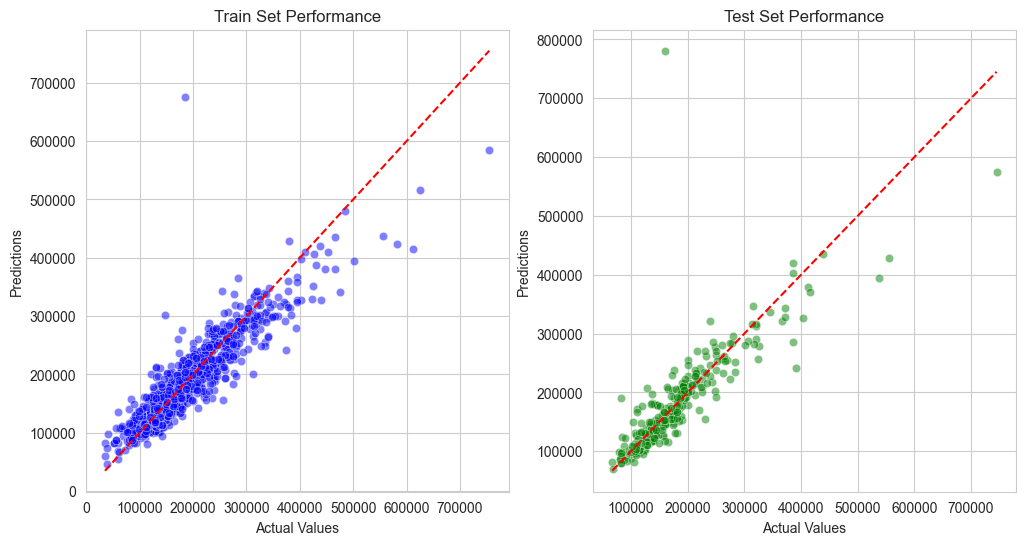

In [105]:
regression_performance(X_train, y_train, X_test, y_test, best_pipeline_ridge)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline_ridge)

Also bit of a failure...
Train = 0.83
Test = 0.674

Time for BaysianRidge

In [106]:
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define the models
models_tune_search_bayesian = {
    "BayesianRidge": BayesianRidge()
}

# Define the hyperparameters for GridSearchCV
params_tune_search_bayesian = {
    "BayesianRidge": {
        'model__regressor__max_iter': [300, 500, 1000],  # Maximum number of iterations
        'model__regressor__alpha_1': [1e-6, 1e-4],  # Hyperparameter for the alpha prior
        'model__regressor__alpha_2': [1e-6, 1e-4],  # Hyperparameter for the alpha prior
        'model__regressor__lambda_1': [1e-6, 1e-5, 1e-4],  # Hyperparameter for the lambda prior
        'model__regressor__lambda_2': [1e-6, 1e-5, 1e-4]  # Hyperparameter for the lambda prior
    }
}

In [107]:
search_tuned_bayesian = HyperparameterOptimizationSearch(models=models_tune_search_bayesian, params=params_tune_search_bayesian, target_transformer=target_transformation_pipeline)
search_tuned_bayesian.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5, refit=True)


Running GridSearchCV for BayesianRidge 

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END model__regressor__colsample_bytree=0.8, model__regressor__learning_rate=0.01, model__regressor__max_depth=3, model__regressor__min_child_weight=1, model__regressor__n_estimators=300, model__regressor__subsample=0.8; total time=   3.3s
[CV] END model__regressor__colsample_bytree=0.8, model__regressor__learning_rate=0.01, model__regressor__max_depth=3, model__regressor__min_child_weight=1, model__regressor__n_estimators=300, model__regressor__subsample=1.0; total time=   2.4s
[CV] END model__regressor__colsample_bytree=0.8, model__regressor__learning_rate=0.01, model__regressor__max_depth=3, model__regressor__min_child_weight=5, model__regressor__n_estimators=100, model__regressor__subsample=0.8; total time=   2.4s
[CV] END model__regressor__colsample_bytree=0.8, model__regressor__learning_rate=0.01, model__regressor__max_depth=3, model__regressor__min_child_weight=5, model__

In [108]:
models_tune_summary_bayesian, models_tune_pipelines_bayesian = search_tuned_bayesian.score_summary(sort_by='mean_score')
models_tune_summary_bayesian

,estimator,min_score,mean_score,max_score,std_score,model__regressor__alpha_1,model__regressor__alpha_2,model__regressor__lambda_1,model__regressor__lambda_2,model__regressor__max_iter
45,BayesianRidge,0.530958,0.805027,0.880719,0.137088,0.000001,0.0001,0.0001,0.000001,300
46,BayesianRidge,0.530958,0.805027,0.880719,0.137088,0.000001,0.0001,0.0001,0.000001,500
47,BayesianRidge,0.530958,0.805027,0.880719,0.137088,0.000001,0.0001,0.0001,0.000001,1000
101,BayesianRidge,0.530958,0.805027,0.880719,0.137088,0.0001,0.0001,0.0001,0.000001,1000
100,BayesianRidge,0.530958,0.805027,0.880719,0.137088,0.0001,0.0001,0.0001,0.000001,500
...,...,...,...,...,...,...,...,...,...,...
8,BayesianRidge,0.530837,0.804984,0.880719,0.137127,0.000001,0.000001,0.000001,0.0001,1000
7,BayesianRidge,0.530837,0.804984,0.880719,0.137127,0.000001,0.000001,0.000001,0.0001,500
62,BayesianRidge,0.530837,0.804984,0.880719,0.137127,0.0001,0.000001,0.000001,0.0001,1000
61,BayesianRidge,0.530837,0.804984,0.880719,0.137127,0.0001,0.000001,0.000001,0.0001,500


In [109]:
# Saving Summary and pipelines
joblib.dump(models_tune_pipelines_bayesian, 'models/hypothesis_3/bayesian_run_1_pipelines.pkl')
models_tune_summary_bayesian.to_csv('models/hypothesis_3/bayesian_run_1_summary.csv', index=False)

In [110]:
best_model_bayesian = models_tune_summary_bayesian.iloc[0, 0]
best_model_bayesian

'BayesianRidge'

In [111]:
best_parameters_bayesian = models_tune_pipelines_bayesian[best_model_bayesian].best_params_
best_parameters_bayesian

{'model__regressor__alpha_1': 1e-06,
 'model__regressor__alpha_2': 0.0001,
 'model__regressor__lambda_1': 0.0001,
 'model__regressor__lambda_2': 1e-06,
 'model__regressor__max_iter': 300}

In [112]:
best_pipeline_bayesian = models_tune_pipelines_bayesian[best_model_bayesian].best_estimator_
best_pipeline_bayesian

Pipeline(steps=[('pre_transformations',
                 Pipeline(steps=[('ordinal_encoder',
                                  OrdinalEncoder(cols=['BsmtExposure',
                                                       'BsmtFinType1',
                                                       'GarageFinish',
                                                       'KitchenQual'],
                                                 mapping=[{'col': 'BsmtExposure',
                                                           'data_type': dtype('O'),
                                                           'mapping': None    0
No      1
Mn      2
Av      3
Gd      4
dtype: int64},
                                                          {'col': 'BsmtFinType1',
                                                           'data_type': dtype('O'),
                                                           'mapping': None    0
Unf     1
LwQ     2
Rec     3
BLQ     4
ALQ     5
GLQ     6
dtype: int64},
                                                          {'co...
                                                        'xxx_TotalLivingArea_mul_OverallCond',
                                                        'xxx_1stFlrSF_mul_OverallQual'])),
                                 ('feature_extractor', FeatureExtractor()),
                                 ('scaler', CustomStandardScaler())])),
                ('feat_selection', SelectFromModel(estimator=BayesianRidge())),
                ('model',
                 TransformedTargetRegressor(regressor=BayesianRidge(alpha_2=0.0001,
                                                                    lambda_1=0.0001,
                                                                    max_iter=300),
                                            transformer=Pipeline(steps=[('log_transform',
                                                                         LogTransformer())])))])

Model Evaluation 

* Train Set
R2 Score: 0.843
Mean Absolute Error: 19128.559


* Test Set
R2 Score: 0.668
Mean Absolute Error: 21025.587




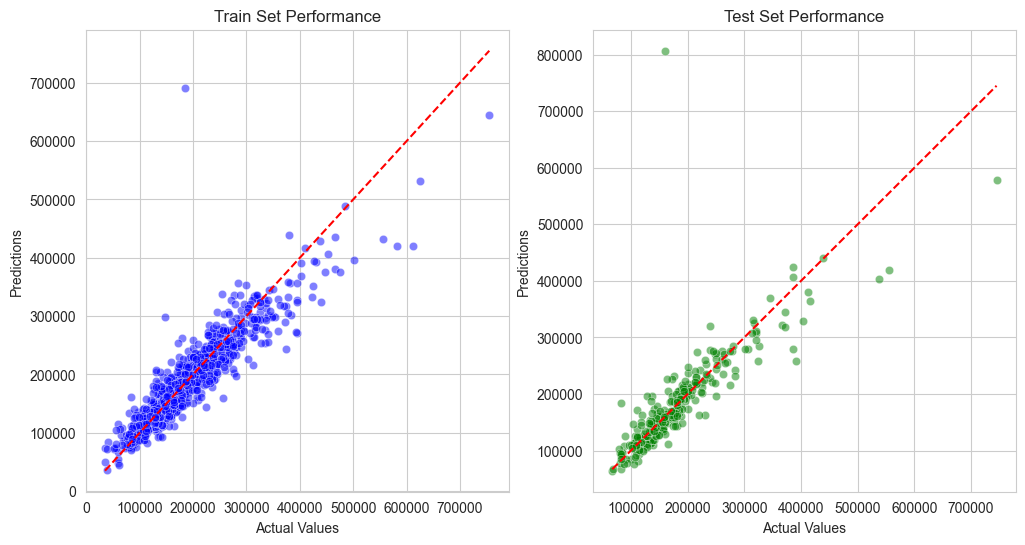

In [114]:
regression_performance(X_train, y_train, X_test, y_test, best_pipeline_bayesian)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline_bayesian)

Train = 0.843
Test = 0.668

### So far we can see, that the best one from all was CATBoostRegressor.